# Predicting_ActiveUsers_TimeSeries

#### Time Series Modeling: Predicting Active Users on a Web Site

In [96]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as m
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller


import scipy
from scipy.stats import boxcox


In [19]:
# Formatation for graphs
plt.style.use('ggplot')
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'

In [20]:
# Data load
data = pd.read_csv('dataset.csv', header = None)

In [21]:
data.head()

,0,1
0,2013-01,110
1,2013-02,121
2,2013-03,135
3,2013-04,127
4,2013-05,128


In [22]:
data.columns = ['month', 'active_users']

In [23]:
data.head()

,month,active_users
0,2013-01,110
1,2013-02,121
2,2013-03,135
3,2013-04,127
4,2013-05,128


In [25]:
data.shape

(144, 2)

In [26]:
data.dtypes

month           object
active_users     int64
dtype: object

In [27]:
type(data)

pandas.core.frame.DataFrame

In [28]:
data.describe()

,active_users
count,144.000000
mean,280.416667
std,119.825543
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [29]:
data.min()

month           2013-01
active_users        104
dtype: object

In [30]:
data.max()

month           2024-12
active_users        622
dtype: object

In [31]:
print('Start of Time Period: {}\nEnd of Time Period: {}'.format(data.month.min(), data.month.max()))

Start of Time Period: 2013-01
End of Time Period: 2024-12


In [32]:
# Convertion to date time
data['month'] = pd.to_datetime(data['month'], format= '%Y-%m')

In [33]:
data.dtypes

month           datetime64[ns]
active_users             int64
dtype: object

In [34]:
data.head()

,month,active_users
0,2013-01-01,110
1,2013-02-01,121
2,2013-03-01,135
3,2013-04-01,127
4,2013-05-01,128


In [35]:
# Convert index
data_serie = data.set_index('month')

In [36]:
data_serie.head()

,active_users
month,
2013-01-01,110
2013-02-01,121
2013-03-01,135
2013-04-01,127
2013-05-01,128


In [37]:
data_serie.index

DatetimeIndex(['2013-01-01', '2013-02-01', '2013-03-01', '2013-04-01', '2013-05-01', '2013-06-01', '2013-07-01', '2013-08-01', '2013-09-01', '2013-10-01',
               ...
               '2024-03-01', '2024-04-01', '2024-05-01', '2024-06-01', '2024-07-01', '2024-08-01', '2024-09-01', '2024-10-01', '2024-11-01', '2024-12-01'], dtype='datetime64[ns]', name='month', length=144, freq=None)

In [38]:
# Checking Missing Values
data_serie.isnull().sum()

active_users    0
dtype: int64

#### Plot - Trend Analysis

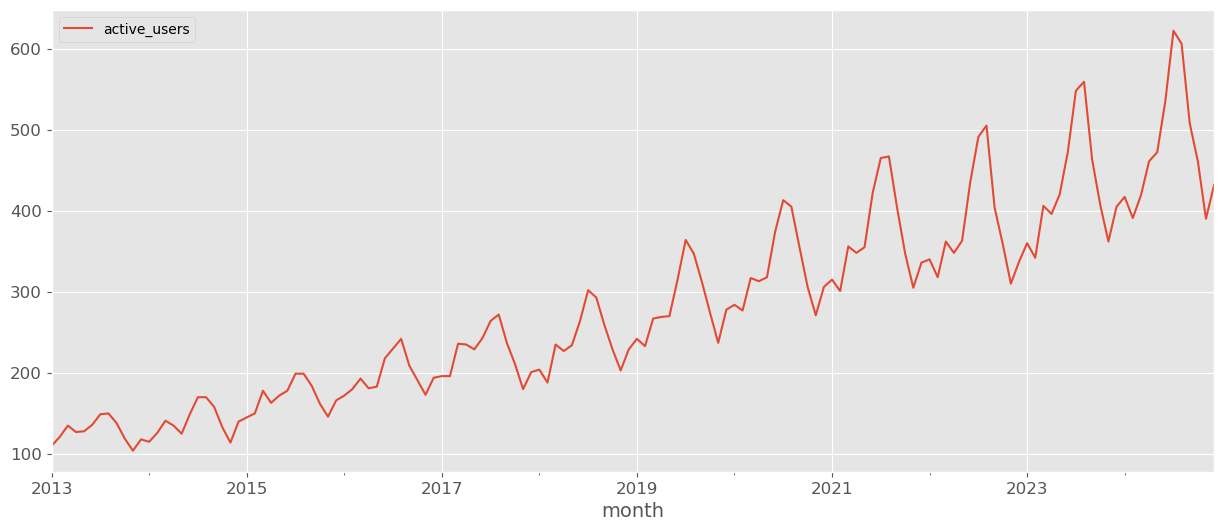

In [39]:
# First Plot
data_serie.plot(figsize= (15, 6))
plt.show()

###  Elements
* Seasonality
* Trend

#### Plot - Second Trend Analysis

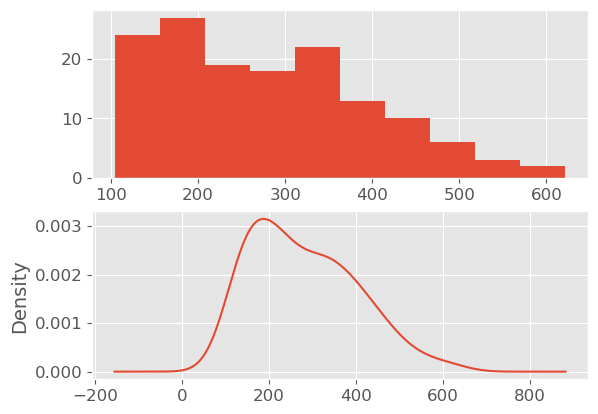

In [40]:
# Plot
plt.figure(1)

# Subplot 1
plt.subplot(211)
data_serie.active_users.hist()

# Subplot 2
plt.subplot(212)
data_serie.active_users.plot(kind = 'kde')
plt.show()

#### Analysis:

- The distribution is not perfectly Gaussian (normal distribution).
- The distribution is skewed to the left.
- Transformations may be useful before modeling.

#### Box Plots - Trend Analysis

Text(0, 0.5, '\nActive Users')

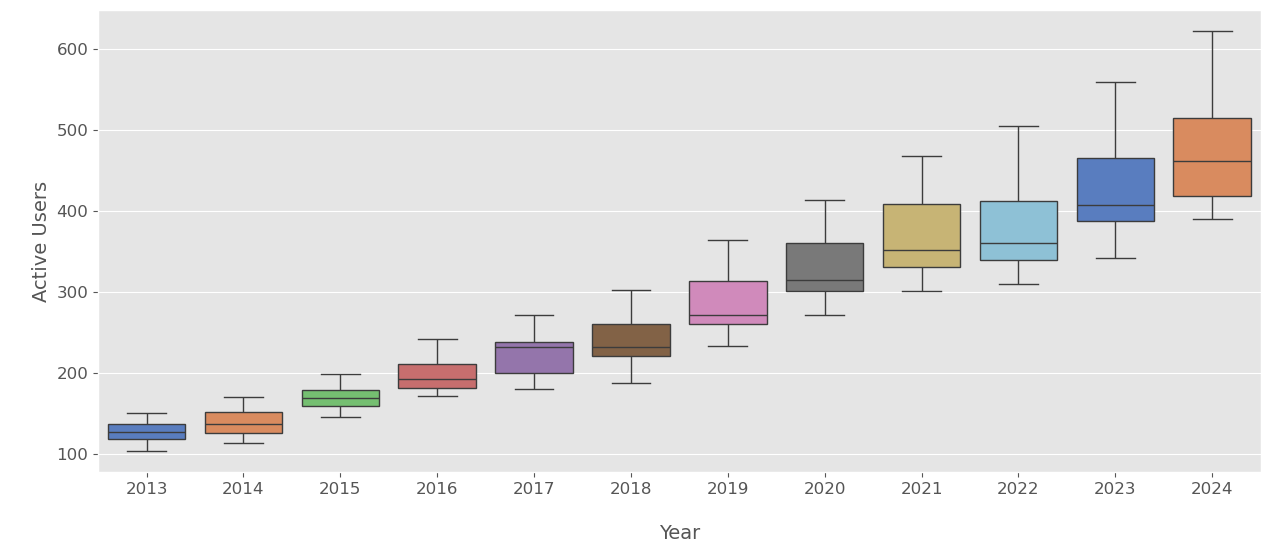

In [59]:
# 
fig, ax = plt.subplots(figsize = (15,6))

year_index = data_serie.active_users.index.year
value = data_serie.active_users


sns.boxplot(x= year_index, hue= year_index, y = value, ax = ax, data = data_serie, palette="muted", legend=False)


plt.xlabel("\nYear")
plt.ylabel("\nActive Users")

#### Analysis:

- The increase in the median over the years confirms an upward trend.
- The dispersion around the median of the data is steadily increasing over time. The boxes are getting larger and larger.
- A model considering seasonality may work well to predict this series.

#### Time Series Decomposition

In [60]:
# Multiplicative Decomposition
multiplicative_decomposition = sm.tsa.seasonal_decompose(data_serie, model= 'multiplicative', extrapolate_trend= 'freq')

In [61]:
type(multiplicative_decomposition)

statsmodels.tsa.seasonal.DecomposeResult

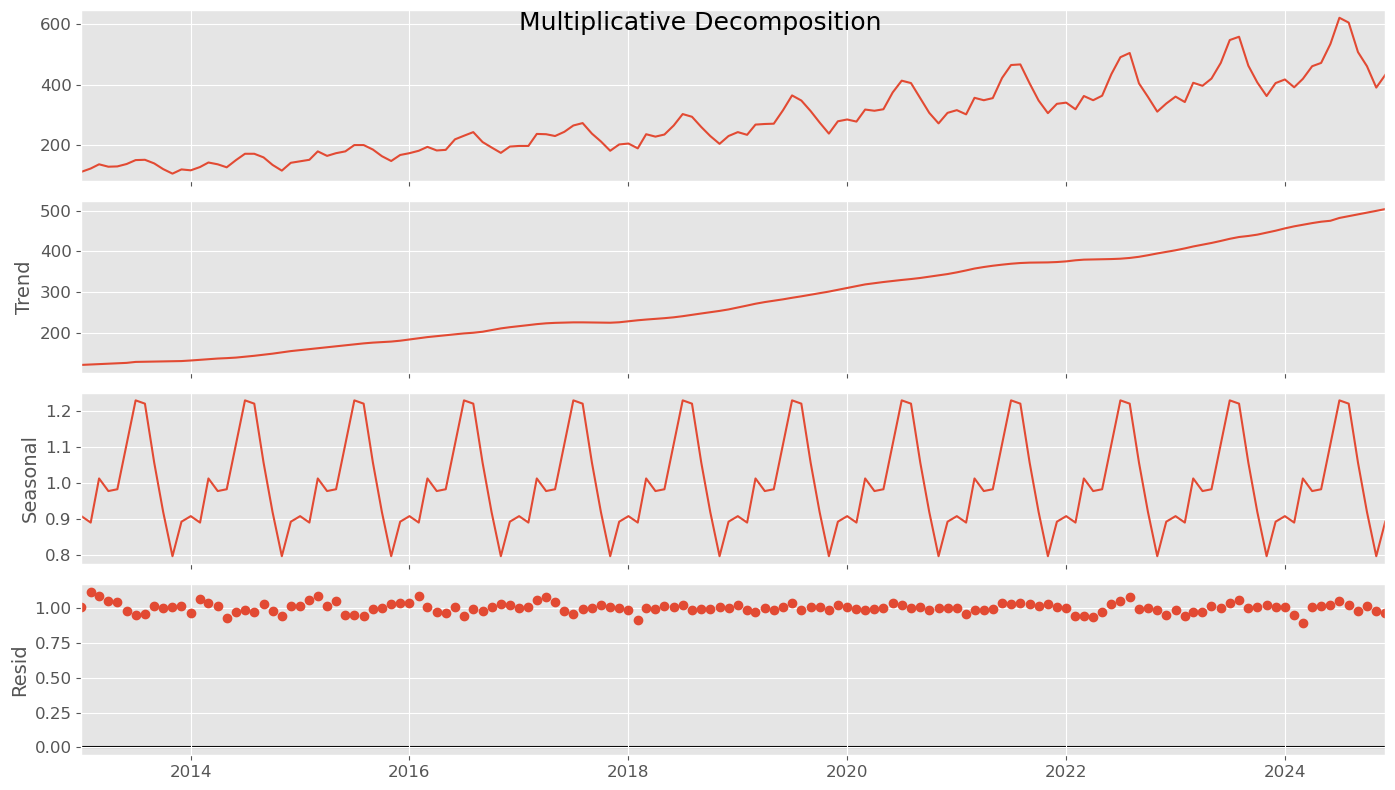

In [67]:
# Plot
plt.rcParams.update({'figure.figsize': (14, 8)})
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize = 18)
plt.show()

In [65]:
# Additive Decomposition
additive_decomposition = sm.tsa.seasonal_decompose(data_serie, model= 'aditive', extrapolate_trend= 'freq')

In [66]:
type(additive_decomposition)

statsmodels.tsa.seasonal.DecomposeResult

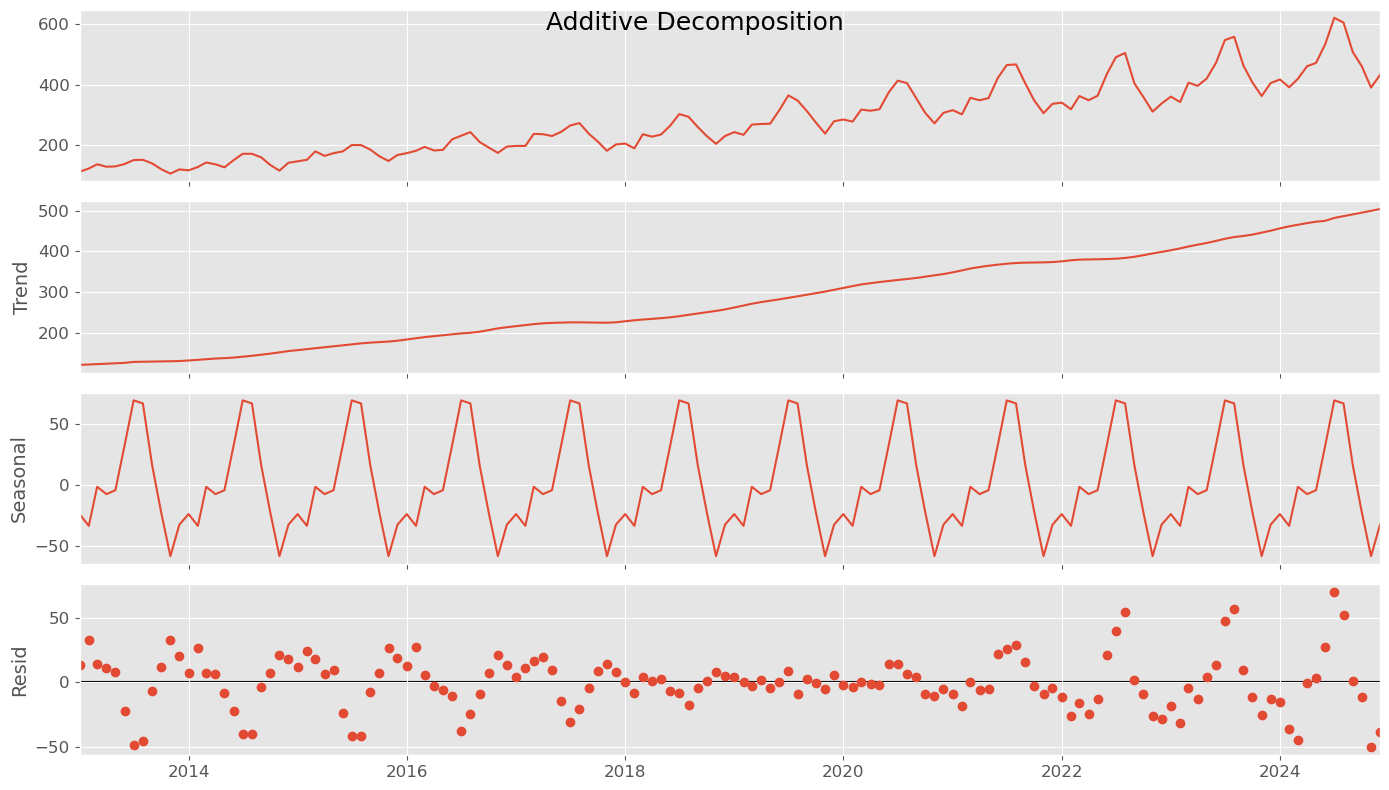

In [68]:
# Plot
plt.rcParams.update({'figure.figsize': (14,8)})
additive_decomposition.plot().suptitle('Additive Decomposition', fontsize = '18')
plt.show()


#### Analysis

1- Serie
Graph shows the observed data.

2 - Trend
Shows the trend of the series, which is clearly a growth trend.

3 - Seasonal
Clearly have regular periods of increase and decrease. This can perhaps be explained by calendar-based events (summer, winter, school holidays, etc...).

4 - Irregular component or residual
Setting **extrapolate_trend = 'freq'** removes NaN values ​​in the trend and residuals (if any, of course).

The residuals from the additive decomposition, it does show some pattern. The multiplicative decomposition, however, looks quite random, which is good.

So ideally, multiplicative decomposition should be preferred for this particular series.


#### Extraction Components 

Extraction rule:

**Real Values ​​= (seasonal * trend * residue)**

In [69]:
# Concatenation
recontruction_serie_data = pd.concat([multiplicative_decomposition.seasonal, 
                                      multiplicative_decomposition.trend, 
                                      multiplicative_decomposition.resid, 
                                      multiplicative_decomposition.observed], axis = 1)

In [70]:
recontruction_serie_data.columns = ['Seasonality', 'Trend', 'Residuals', 'Observed_Values']

In [71]:
recontruction_serie_data.head()

,Seasonality,Trend,Residuals,Observed_Values
month,,,,
2013-01-01,0.908801,120.743930,1.002440,110.0
2013-02-01,0.890967,121.750194,1.115460,121.0
2013-03-01,1.013081,122.756459,1.085538,135.0
2013-04-01,0.978227,123.762723,1.048997,127.0
2013-05-01,0.983212,124.768988,1.043413,128.0


In [72]:
obs_value = np.round(0.908801 * 120.743930 * 1.002440)
obs_value

110.0

In [78]:
data_serie.head()

,active_users
month,
2013-01-01,110
2013-02-01,121
2013-03-01,135
2013-04-01,127
2013-05-01,128


#### Check whether these statistical properties are constant in the time series:

- **Stationarity**: the time series **must** be stationary, that is, its statistical characteristics, such as mean and variance, do not change over time.

- **Non-autocorrelation**: the observations of the time series should not be strongly correlated with previous observations.

- **Normality**: it is often assumed that the observations of the time series are normally distributed (follow a normal distribution).

### Rolling Statistics

In [80]:
rolmean = data['active_users'].rolling(window= 12).mean()
rolstd = data['active_users'].rolling(window= 12).std()

In [79]:
x = data['month'].values
y = data['active_users'].values

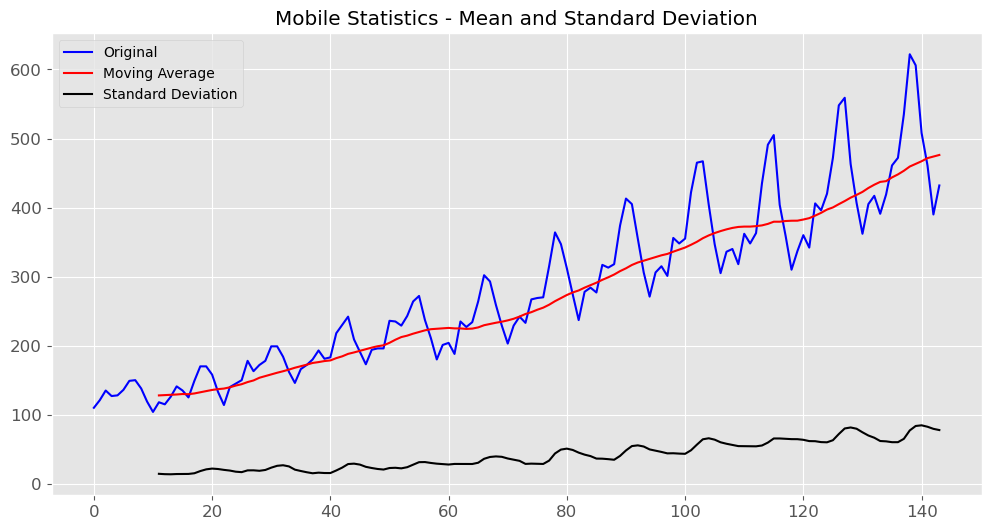

In [83]:
plt.figure(figsize = (12, 6))
orig = plt.plot(y, color = 'blue', label = 'Original')
mean = plt.plot(rolmean, color = 'red', label = 'Moving Average')
std = plt.plot(rolstd, color = 'black', label = 'Standard Deviation')
plt.legend(loc='best')
plt.title('Mobile Statistics - Mean and Standard Deviation')
plt.show()

Analysis:

- We observe that the moving average and the standard deviation are not constant over time (increasing trend).
- The series is therefore not stationary.

### Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) Plots

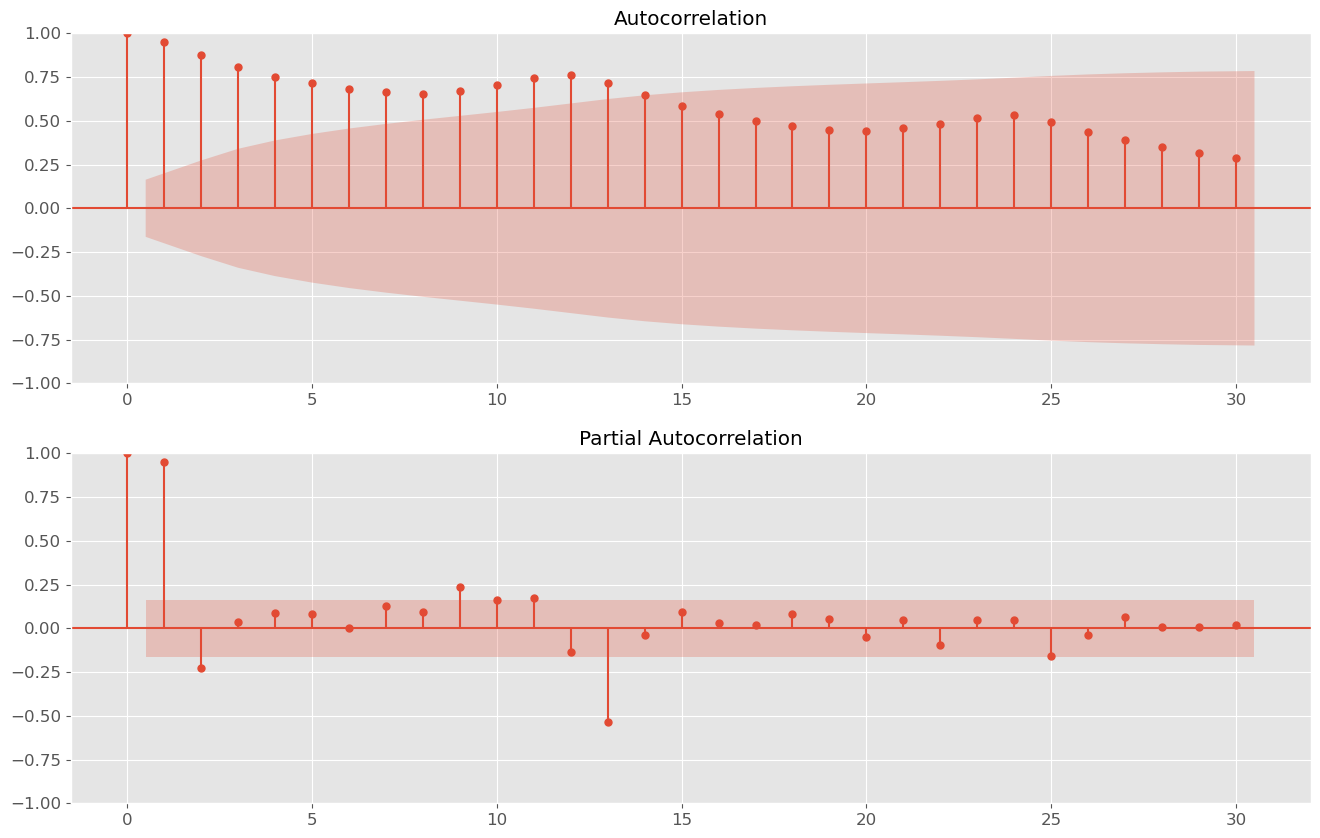

In [94]:
# Plots
plt.rcParams.update({'figure.figsize': (16,10)})

# Plot do gráfico ACF
plt.subplot(211)
plot_acf(data_serie.active_users, ax = plt.gca(), lags = 30)

# Plot do gráfico PACF
plt.subplot(212)
plot_pacf(data_serie.active_users, ax = plt.gca(), lags = 30, method = 'ywm')
plt.show()

##### Analysis:

- If the time series is stationary, the ACF/PACF plots will show a "rapid drop in correlation" after a short delay between points. This is not the case in our plots. The slow drop (reduction in bar size) indicates that this series is not stationary.

- Our data series is not stationary because a high number of past observations are correlated with future values.

- Confidence intervals are drawn in the shaded area. By default, this is set to a 95% confidence interval, suggesting that correlation values ​​outside this area are likely to be a correlation and not a statistical fluke.

- We will need to make this series stationary before creating a predictive model.

#### Augmented Dickey-Fuller Statistical Test

In [95]:
# Teste Dickey-Fuller

# Print
print('\nResult of Teste Dickey-Fuller:\n')

# Teste
dftest = adfuller(data_serie.active_users, autolag = 'AIC')

# Formatando a saída
dfout = pd.Series(dftest[0:4], index = ['Test Statistic',
                                           'p-Value',
                                           'Number of Lags Considered',
                                           'Number of Observations Used'])

# Loop por cada item da saída do teste
for key,value in dftest[4].items():
    dfout['Critical Value (%s)'%key] = value

# Print
print (dfout)


Result of Teste Dickey-Fuller:

Test Statistic                   0.809204
p-Value                          0.991783
Number of Lags Considered       13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


Analysis:

- The p-value is greater than 0.05. We have no statistical evidence to reject the null hypothesis that the series is not stationary. Therefore, we can conclude that the series is NOT stationary.

#### Methods for transforming the series into stationary

In [97]:
# Transformation LOG
data_serie['active_users_log'] = np.log(data_serie['active_users'])

In [98]:
data_serie.head()

,active_users,active_users_log
month,,
2013-01-01,110,4.700480
2013-02-01,121,4.795791
2013-03-01,135,4.905275
2013-04-01,127,4.844187
2013-05-01,128,4.852030


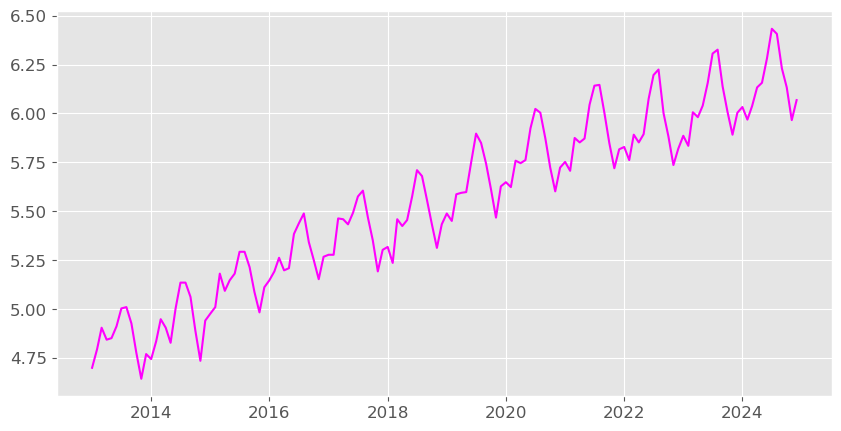

In [99]:
# Plot Transformed Serie
plt.figure(figsize= (10, 5))
plt.plot(data_serie['active_users_log'], color = 'magenta')
plt.show()

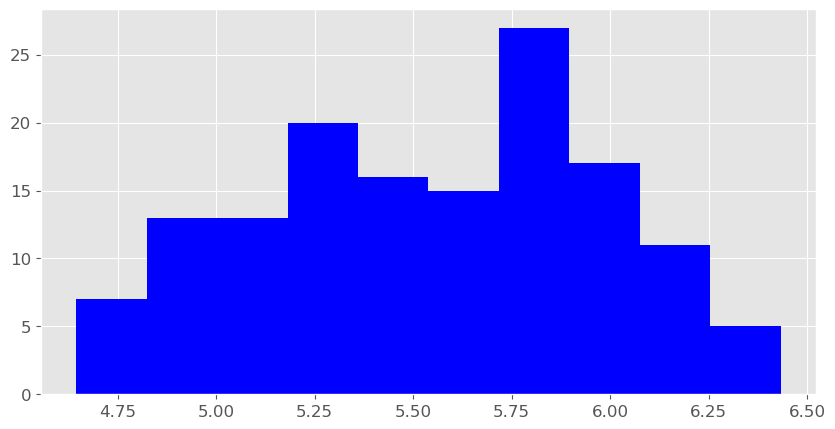

In [100]:
# Histogram of Transformed Serie
plt.figure(figsize= (10, 5))
plt.hist(data_serie['active_users_log'], color = 'blue')
plt.show()

#### Analysis:

- The line graph shows apparently linear growth and variation.

- The histogram also shows a more uniform Gaussian-like distribution of observations.

In [110]:
# Function to test stationarity
def stationarity_test(serie, window = 12, title='Rolling Statistics and Dickey-Fuller Test'):

    # Calculate rolling statistics
    rolmean = serie.rolling(window = window).mean()
    rolstd = serie.rolling(window = window).std()

    # Plot of rolling statistics
    plt.figure(figsize = (14, 6))
    plt.plot(serie, color = 'blue', label = 'Original')
    plt.plot(rolmean, color = 'red', label = 'Moving Average') 
    plt.plot(rolstd, color = 'black', label = 'Moving Standard Deviation')
    plt.legend(loc='best')
    plt.title(title)
    plt.show(block=False)

    # Dickey-Fuller Test
    print('\nDickey-Fuller Test Result:')
    dftest = adfuller(serie, autolag='AIC')
    dfout = pd.Series(dftest[0:4], index = ['Test Statistic',
                                            'p-Value',
                                            'Number of Lags Considered',
                                            'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfout['Critical Value (%s)' % key] = value

    print(dfout)

    # Conclusion based on p-value
    if dfout['p-Value'] > 0.05:
        print('\nConclusion:\nThe p-value is greater than 0.05 and therefore we have no evidence to reject the null hypothesis.\nThis series is probably not stationary.')
    else:
        print('\nConclusion:\nThe p-value is less than 0.05 and therefore we have evidence to reject the null hypothesis.\nThis series is probably stationary.')


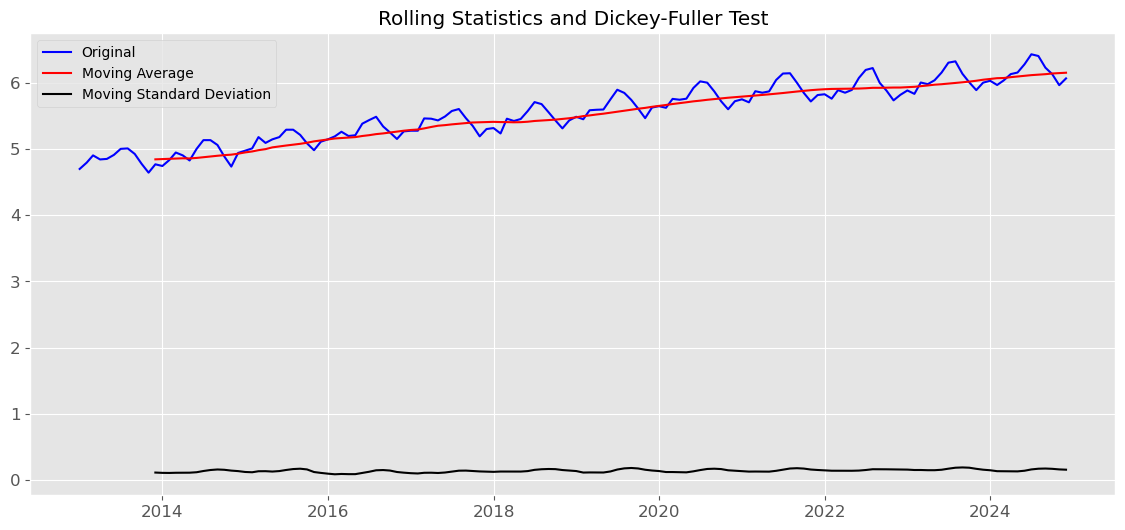


Dickey-Fuller Test Result:
Test Statistic                  -1.682091
p-Value                          0.440363
Number of Lags Considered       13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64

Conclusion:
The p-value is greater than 0.05 and therefore we have no evidence to reject the null hypothesis.
This series is probably not stationary.


In [111]:
stationarity_test(data_serie['active_users_log'])


In [112]:
# Square Root Transformation
data_sqrt = np.sqrt(data_serie['active_users'])

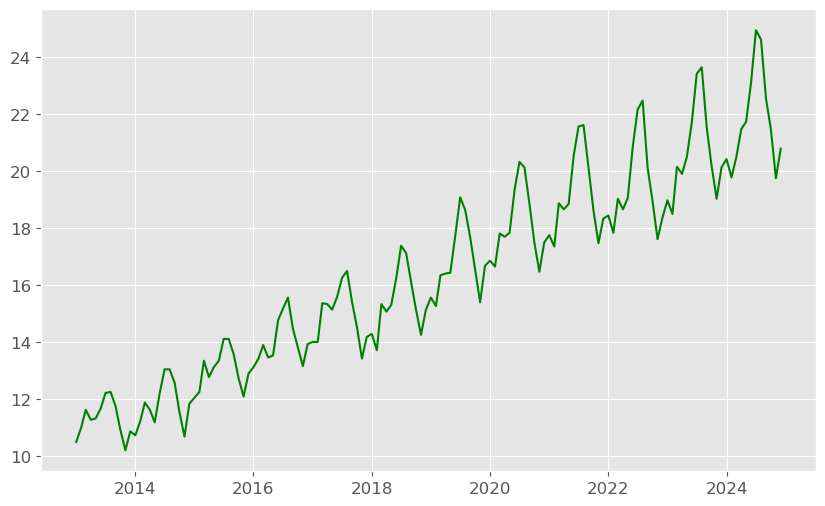

In [113]:
# Line Plot
plt.figure(figsize=(10, 6))
plt.plot(data_sqrt, color = "green")
plt.show()

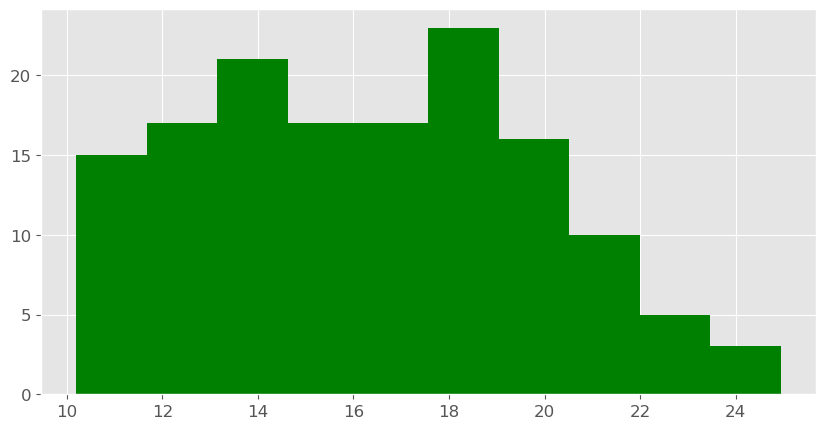

In [114]:
# Histogram
plt.figure(figsize = (10, 5))
plt.hist(data_sqrt, color = "green")
plt.show()

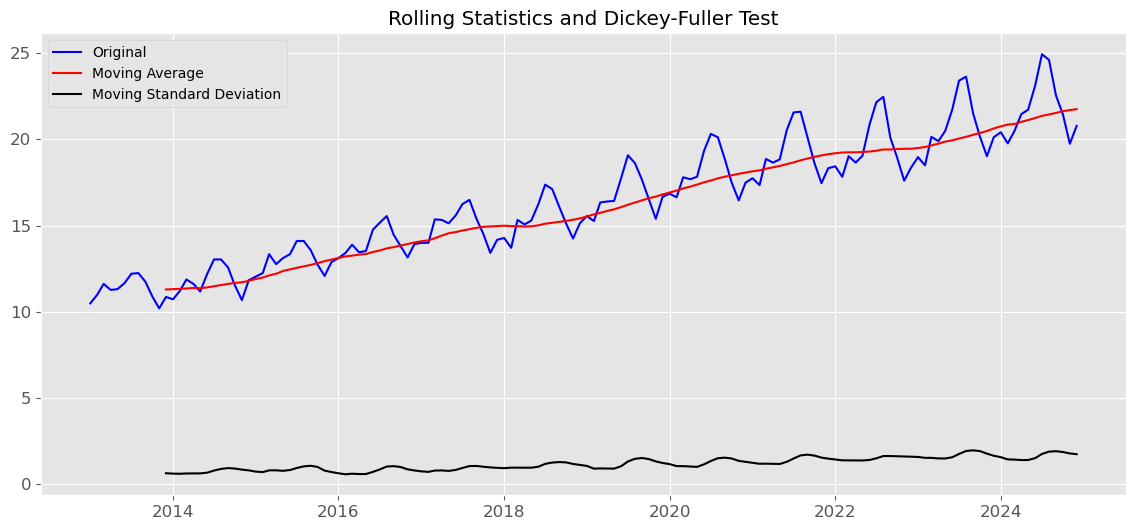


Dickey-Fuller Test Result:
Test Statistic                  -0.335165
p-Value                          0.920374
Number of Lags Considered       13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64

Conclusion:
The p-value is greater than 0.05 and therefore we have no evidence to reject the null hypothesis.
This series is probably not stationary.


In [115]:
stationarity_test(data_sqrt)

#### Analysis:

- We can see that the trend has been reduced, but not removed.

- The line graph still shows increasing variation from cycle to cycle. And the histogram still shows a long tail on the right of the distribution, suggesting an exponential or long-tailed distribution.

In [116]:
# Box-Cox Transformation
data_serie['active_users_box'] = boxcox(data_serie['active_users'], lmbda = 0.0)

In [117]:
data_serie.head()

,active_users,active_users_log,active_users_box
month,,,
2013-01-01,110,4.700480,4.700480
2013-02-01,121,4.795791,4.795791
2013-03-01,135,4.905275,4.905275
2013-04-01,127,4.844187,4.844187
2013-05-01,128,4.852030,4.852030


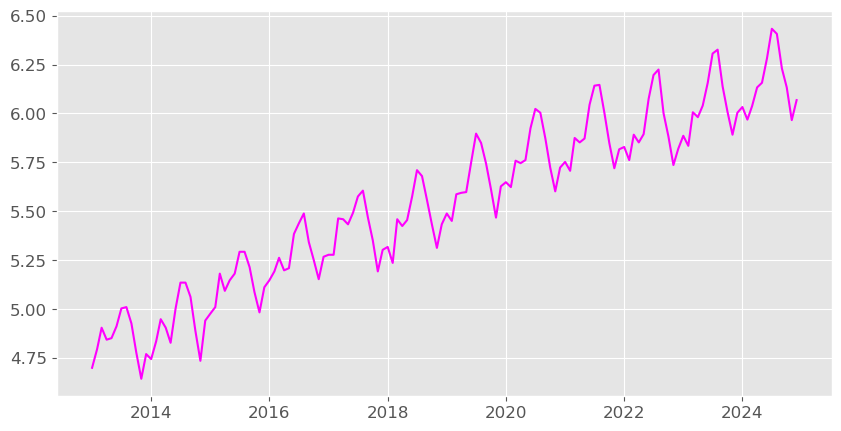

In [118]:
# Plot da série transformada
plt.figure(figsize = (10, 5))
plt.plot(data_serie['active_users_box'], color = "magenta")
plt.show()

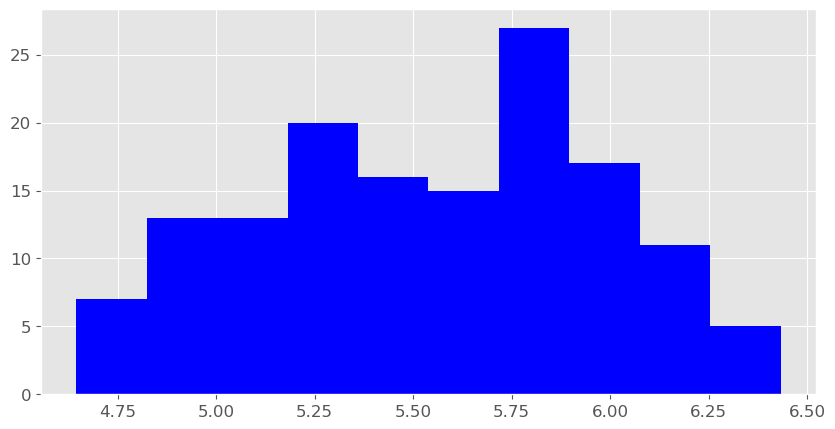

In [119]:
# Histograma
plt.figure(figsize = (10, 5))
plt.hist(data_serie['active_users_box'], color = "blue")
plt.show()

We can set the lambda parameter to None (the default) and let the function find a statistically adjusted value.

In [120]:
# Box-Cox Transformation 2 -  lambda value 
data_serie['active_users_box_2'], lam_value = boxcox(data_serie['active_users'])
print('Ideal Lambda Value: %f' % lam_value)
data_serie.head()

Ideal Lambda Value: 0.141909


,active_users,active_users_log,active_users_box,active_users_box_2
month,,,,
2013-01-01,110,4.700480,4.700480,6.683589
2013-02-01,121,4.795791,4.795791,6.870559
2013-03-01,135,4.905275,4.905275,7.088477
2013-04-01,127,4.844187,4.844187,6.966470
2013-05-01,128,4.852030,4.852030,6.982076


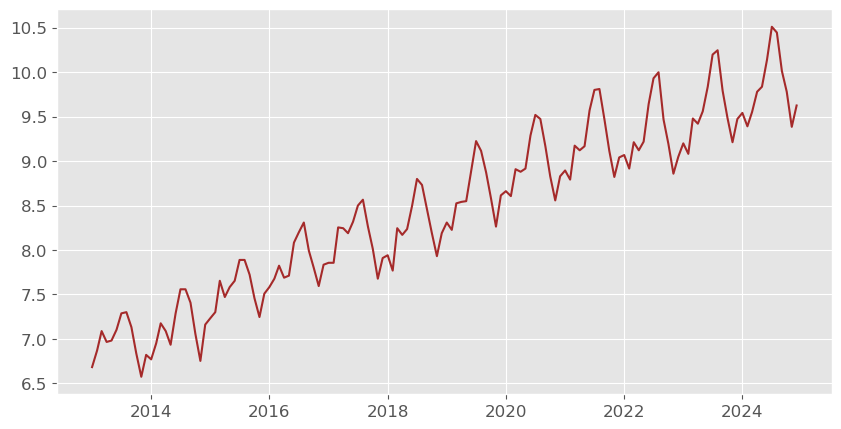

In [121]:
# Plot da série transformada
plt.figure(figsize = (10, 5))
plt.plot(data_serie['active_users_box_2'], color = "brown")
plt.show()

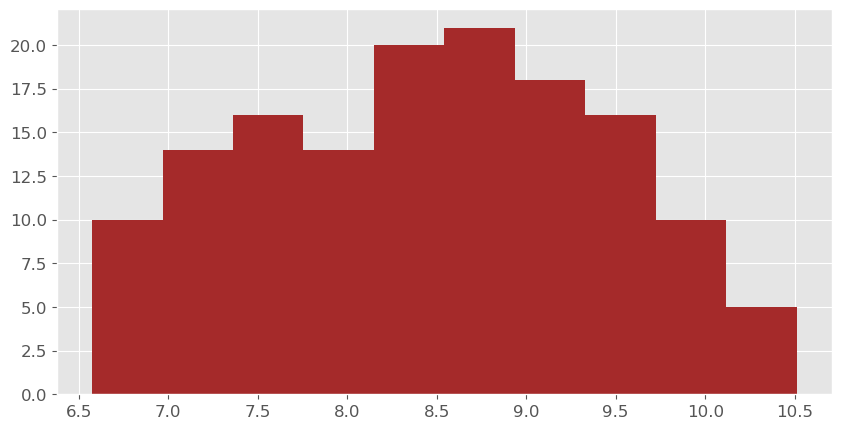

In [122]:
# Histogram
plt.figure(figsize = (10, 5))
plt.hist(data_serie['active_users_box_2'], color = "brown")
plt.show()

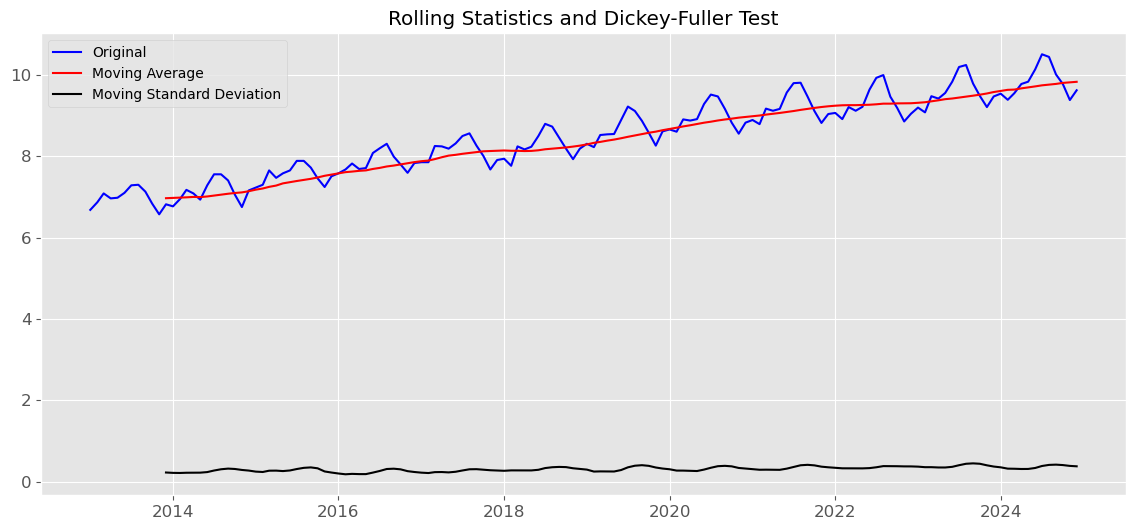


Dickey-Fuller Test Result:
Test Statistic                  -1.313294
p-Value                          0.623069
Number of Lags Considered       13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64

Conclusion:
The p-value is greater than 0.05 and therefore we have no evidence to reject the null hypothesis.
This series is probably not stationary.


In [123]:
stationarity_test(data_serie['active_users_box_2'])

#### Analysis:

- Running the example yielded a lambda value of 0.141909.

- We can see that this is very close to a lambda value of 0.0, resulting in a stronger (and smaller) log transformation than 0.5 for the square root transformation.

It appears that none of the previous techniques have worked to make our series stationary. So we will have to move up a level and apply more advanced techniques.

In [125]:
data_serie.head()

,active_users,active_users_log,active_users_box,active_users_box_2
month,,,,
2013-01-01,110,4.700480,4.700480,6.683589
2013-02-01,121,4.795791,4.795791,6.870559
2013-03-01,135,4.905275,4.905275,7.088477
2013-04-01,127,4.844187,4.844187,6.966470
2013-05-01,128,4.852030,4.852030,6.982076


In [ ]:
data_serie = data_serie.drop(columns=['active_users_log', 'active_users_box', 'active_users_box_2'])

In [148]:
data_serie.head()

,active_users,active_users_box_2
month,,
2013-01-01,110,6.683589
2013-02-01,121,6.870559
2013-03-01,135,7.088477
2013-04-01,127,6.966470
2013-05-01,128,6.982076


In [149]:
data_serie = data_serie.drop(columns=['active_users_box_2'])

In [150]:
data_serie.head()

,active_users
month,
2013-01-01,110
2013-02-01,121
2013-03-01,135
2013-04-01,127
2013-05-01,128


In [151]:
df_serie = data_serie.copy()

In [152]:
df_serie.head()

,active_users
month,
2013-01-01,110
2013-02-01,121
2013-03-01,135
2013-04-01,127
2013-05-01,128


In [154]:
type(data_serie)

pandas.core.frame.DataFrame

In [155]:
data_serie['active_users'].mean()

280.4166666666667

In [167]:
data_serie['active_users_moving_average_simple'] = data_serie.rolling(window=12).mean()

ValueError: Cannot set a DataFrame with multiple columns to the single column active_users_moving_average_simple

In [ ]:
data_serie

In [ ]:
data_serie.head(20)

In [ ]:
data_serie.tail(20)

In [ ]:
# Plot
plt.plot(data_serie['active_users'], color = 'magenta')
plt.show();

In [ ]:
# Plot of the smoothed series
plt.plot(data_serie['active_users_moving_average_simple'], color = 'blue')
plt.show();

In [ ]:
# Together
plt.plot(data_serie['active_users'], color = 'magenta')
plt.plot(data_serie['active_users_moving_average_simple'], color = 'blue')
plt.show();

In [ ]:
# Calculating the difference between the original series and the smoothed series
diff_original_smoothed = data['active_users'] - data['active_users_simple_moving_media']
diff_original_smoothed.tail(20)

In [ ]:
# Remove values NA 
diff_original_smoothed.dropna(inplace = True)

In [ ]:
stationarity_test(diff_original_smoothed)

We applied smoothing and extracted the trend from the series. This series has been transformed and we could now use it for statistical modeling. But we have a problem. We lost part of the data, part that could be important for predicting future behavior.

Let's try another smoothing technique and see if we are successful without losing so much data.

#### Smoothing Using Exponential Weighted Moving Average

In [ ]:
# Applying exponential smoothing
exp_smoothed_serie = data_serie.ewm(alpha = 0.2, adjust = True).mean()



In [ ]:
exp_smoothed_serie

In [ ]:
# Plot
plt.plot(data_serie)
plt.plot(exp_smoothed_serie, color = 'magenta')
plt.show();

In [ ]:
# calculate the difference and apply the stationarity test

diff_original_smoothed_exp = data_serie.active_user - exp_smoothed_serie.active_users

In [ ]:
stationarity_test(diff_original_smoothed_exp)

#### Smoothing Results:
With simple moving average smoothing we can transform our series into stationary, but we lose data.

With exponential moving average smoothing we do not lose data, but we do not convert the series into stationary.